In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
#from evaluation_functions import ensemble_evaluation_functions as eef
#import sunspots.sunspots as sunspots
import re  #for dealing with non-numeric characters in a string of unknown length

import matplotlib as mpl
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin
#from calibration_functions import huxt_rank_functions as hrf

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit

from sunpy.coordinates.sun import carrington_rotation_time
from sunpy.coordinates.sun import carrington_rotation_number

# ensemble functions
import huxt_ensemble_functions as hef 

c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')
omni_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

In [58]:
def compute_lead_time_stats(df):

    df_ = df.copy()
    # Calculating the statistics
    df_['mean'] = df_.mean(axis=1)
    df_['median'] = df_.median(axis=1)
    df_['min'] = df_.min(axis=1)
    df_['max'] = df_.max(axis=1)
    df_['lower_1_sigma'] = df_.apply(lambda row: np.percentile(row, 15.87), axis=1)
    df_['upper_1_sigma'] = df_.apply(lambda row: np.percentile(row, 84.13), axis=1)
    df_['lower_2_sigma'] = df_.apply(lambda row: np.percentile(row, 2.28), axis=1)
    df_['upper_2_sigma'] = df_.apply(lambda row: np.percentile(row, 97.72), axis=1)

    return df_

In [3]:
# get all WSA files with specified keywords
directory_path = H._setup_dirs_()['boundary_conditions']
wsa_file_words = ['wsa_vel'] # keywords to filter for in coronal model file directory
wsa_fnames = hef.get_files_containing_words(directory_path, wsa_file_words)

dates = []
filenames = []

# creating list of filenames of WSA solutions for generating/reading in ensembles
for filename in wsa_fnames:

    # Define regular expression patterns to extract the date from file string
    pattern = r'21.5rs_(\d{4})(\d{2})(\d{2})(\d{2})'
    pattern2 = r'%2F(\d{4})%2F(\d{1,2})%2F(\d{1,2})%2F'
    match = re.search(pattern, filename)
    match2 = re.search(pattern2, filename)
    
    if match:
        year, month, day, hour = match.groups()
        date_string = f'{year}-{month}-{day}--{hour}'
        dates.append(datetime.datetime(int(year), int(month), int(day), int(hour)))
        filenames.append(filename)
    elif match2:
        year, month, day = match2.groups()
        date_string = f'{year}-{month}-{day}'
        dates.append(datetime.datetime(int(year), int(month), int(day), int(0)))
        filenames.append(filename)
    else:
        print(f"No date found in the string: {filename}")


# index filenames by date
df_filenames = pd.DataFrame({'file_string' : filenames}, index = dates)
df_filenames = df_filenames.sort_index()

In [99]:
# specify date range of WAS solutions to generate ensembles for
start_date = datetime.datetime(2019,10,1)
end_date = datetime.datetime(2019,10,30)

date_range = pd.date_range(start_date, end_date, freq='D') # want only daily updated ones/as close to daily as possible

# Finding closest indices
indexer = df_filenames.index.get_indexer(date_range, method='nearest')

# Retrieving the closest rows
closest_files = df_filenames.iloc[indexer]

# Dropping duplicates to keep only unique rows
unique_files = closest_files[~closest_files.index.duplicated(keep='first')]

# list of WSA filenames within date_range
fname_list = unique_files['file_string'].to_list()

ensemble_size = 100
sigma_latitude = 10 # degrees
sigma_longitude = 10 # degrees
forecast_window = 10 * u.day
r_min = 21.5*u.solRad

max_lead_time = 10 # days
fname = fname_list[0]

# params formatted as a tuple to feed to ensemble gen function
params = (fname, ensemble_size, sigma_latitude, forecast_window, r_min)

lead_time_dict = hef.split_by_lead_time(params=params, sigma_longitude=sigma_longitude, 
                                    max_lead_time=max_lead_time, observed_data=omni_data, 
                                    filenames=fname_list)

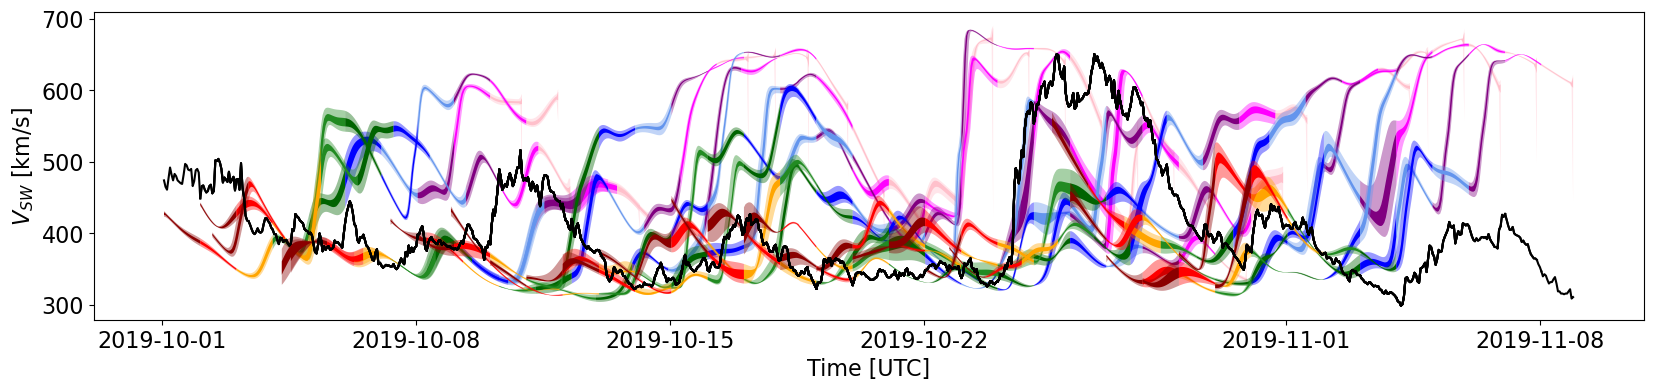

In [100]:
colors = ['darkred', 'red', 'orange', 'forestgreen', 'darkgreen', 'blue', 'cornflowerblue', 'purple', 'magenta', 'pink', 'grey']

plt.figure(figsize = (20,4))
for index in range(len(fname_list)):

    max_lead_time = 10
    for i in range(max_lead_time):

        df_ = lead_time_dict[f'{i+1}_day_lead'][index]
        df_stats = compute_lead_time_stats(df_)

        plt.fill_between(df_stats.index, df_stats['lower_2_sigma'], df_stats['upper_2_sigma'], label = r'2$\sigma$', color = colors[i], alpha = 0.4, edgecolor = None )
        plt.fill_between(df_stats.index, df_stats['lower_1_sigma'], df_stats['upper_1_sigma'], label = r'1$\sigma$', color = colors[i], alpha = 1, edgecolor = None )

        plt.plot(lead_time_dict[f'{i+1}_day_data'][index], color = 'black')

plt.xlabel('Time [UTC]')
plt.ylabel(r'$V_{SW}$ [km/s]')
plt.show()

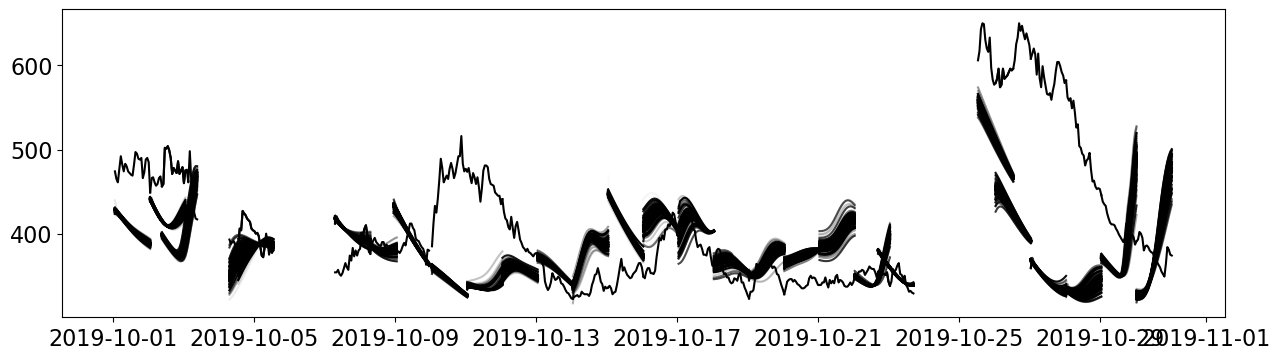

In [105]:
plt.figure(figsize = (15,4))
ensemble_size=100

for df in lead_time_dict['1_day_lead']:
    [plt.plot(df[i], color = 'black', alpha = 1-i/100) for i in range(ensemble_size)]

for i, _ in enumerate(fname_list):
    plt.plot(lead_time_dict[f'1_day_data'][i], color = 'black')

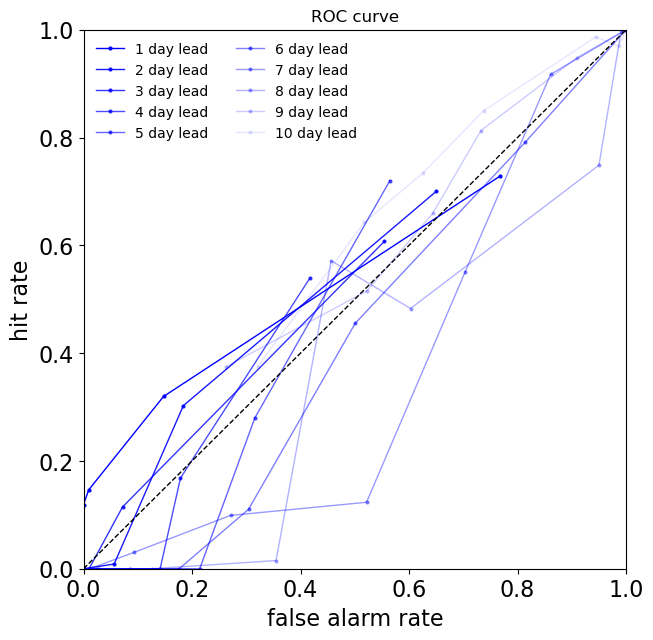

Text(0, 0.5, 'Brier Score')

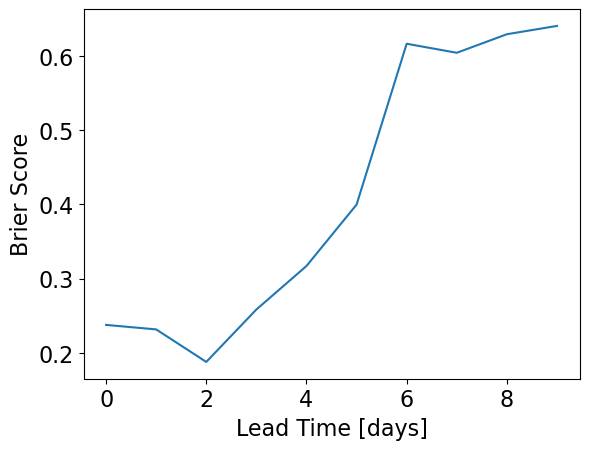

In [101]:
BS_list = []

plt.figure(figsize = (7,7))
max_lead_time = 10
for i in range(max_lead_time):
    df_combined = pd.concat(lead_time_dict[f'{i+1}_day_lead'])
    df_data = pd.concat(lead_time_dict[f'{i+1}_day_data'])

    brier_score = hef.ensemble_brier_score(ensemble_members=df_combined.to_numpy().T, observed_data=df_data.to_numpy(), event_threshold=460, ensemble_size=ensemble_size )
    roc_curve = hef.generate_roc_curve_from_ensemble(ensemble_members=df_combined.to_numpy().T, observed_data=df_data.to_numpy(), threshold_range=(300,800), threshold_num=10, probability_threshold=0.5)

    BS_list.append(brier_score)

    hit_rate, false_alarm_rate = zip(*roc_curve)

    plt.plot(false_alarm_rate, hit_rate, marker = 'o', markersize = 2, linewidth = 1, label = f'{i+1} day lead', color = 'blue', alpha = 1 - i/10)

plt.plot([0,1], [0,1], linestyle = '--', lw = 1, color = 'black')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('ROC curve')
plt.xlabel('false alarm rate')
plt.ylabel('hit rate')
plt.legend(frameon= False, ncols = 2, fontsize = 'medium')
plt.show()

plt.figure()
plt.plot(BS_list)
plt.xlabel('Lead Time [days]')
plt.ylabel('Brier Score')